#####  Parte 3 de 4
#### Ingeniero en Sistemas: Erick J. Pineda Amézquita  
Correo de contacto: epineda.amezquita@gmail.com  
github: https://github.com/epinedaWorks/

Los ejercicios realizados en este notebook son de uso público, se hace la aclaración que el aprendizaje y conocimiento obtenido radica en diversas fuentes, asimismo, la experiencia del autor en desarrollo de software. Se aclara también que la idea del orden del contenido expuesto toma como base el curso impartido en la plataforma de DataCamp:  
https://campus.datacamp.com/courses/image-processing-in-python/  

Las imagenes de ejemplo se encuentran en el directorio "imagenes", se hace referencia por medio de **./imagenes/**  
Si se desea, por facilidad, pueden colocarse en el mismo directorio donde se encuentra el arhivo python o notebook ipynb




# Restauración de imágenes, eliminación de ruido, borrado de objetos, superpixeles y segmentación, encontrar contornos, detección y conteo de objetos

## Procesamiento de imagenes -- Requisitos

Para los siguientes ejemplos, se va a utilizar la herramienta de SCIKIT IMAGE.  
Se requiere instalar dicha librería para hacer uso de todas las funciones que provee la herramienta.  
Para instalar en Windows se requiere acceder a la consola de comandos en modo Administrador y ejecutar la siguiente instrucción:  


**$ pip install scikit-image**  

Si no funciona, probar con:   

**$ conda install -c conda-forge scikit-image**  

No esta de mas realizar un test de los paquetes que se requieren, ya sea antes o después de la instalación de scikit-image por medio de las siguientes instrucciones:  

**$ pytest --pyargs skimage**

Fuente:  
https://scikit-image.org/docs/stable/install.html  
  
**Como primer paso: Ejecutar las siguientes lineas para saber si todo está correcto, si no funciona, revisar instalación**


In [1]:
# Import the modules from skimage
from skimage import data, color

import matplotlib.pyplot as plt
import numpy as np
import cv2


## Funciones básicas para visualizar imágenes

Comenzamos por importar la librería, si la siguiente instrucción muestra error, será necesario revisar la instalación de scikit image.

Se crea un metodo que va a leer las imagenes por medio de matplotlib.

In [2]:
def show_image(image, title='Image', cmap_type='gray'):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()


Se crea una función de comparación para dos imagenes:

In [3]:
def plot_comparison(original, filtered, title_filtered):
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 6), sharex=True,
  sharey=True)
  ax1.imshow(original, cmap=plt.cm.gray)
  ax1.set_title('original')
  ax1.axis('off')
  ax2.imshow(filtered, cmap=plt.cm.gray)
  ax2.set_title(title_filtered)
  ax2.axis('off')


## Analizando coordenadas de una imágen y su manipulación
Función inpaint: Se utiliza para restaurar imágenes dañadas o deterioradas, para quitar objetos, quitar marcas o logos  seleccionando áreas específicas para reemplazar pixeles "no deseados"

Tamaño de la imagen:  (1033, 1280, 3)


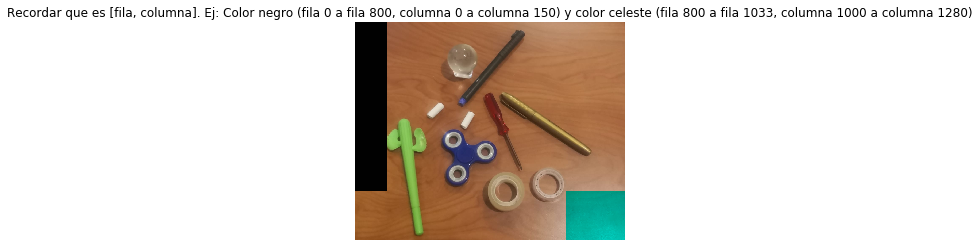

In [4]:
# Import the module from restoration
from skimage.restoration import inpaint


imgName = "./imagenes/lapiceros.JPG"    
imgLapiceros = cv2.imread(imgName)
imgLapicerosRGB = cv2.cvtColor(imgLapiceros, cv2.COLOR_BGR2RGB)

print("Tamaño de la imagen: ",imgLapicerosRGB.shape)

# Parte superior
imgLapicerosRGB[0:800, 0:150] = 1

# Parte inferior, se selecciona un canal específico
imgLapicerosRGB[800:1033, 1000:1280,0] = 1

show_image(imgLapicerosRGB, 'Recordar que es [fila, columna]. Ej: Color negro (fila 0 a fila 800, columna 0 a columna 150) y color celeste (fila 800 a fila 1033, columna 1000 a columna 1280)')

## NOTA IMPORTANTE
Observar que en el ejemplo anterior, al modificar los valores de la imágen, las coordenadas iniciales comienzan en la esquina superior izquierda, es decir, no son coordenadas cartesianas ya que al cargar la imágen por medio de OpenCV éste utiliza el sistema (fila, columna), o también conocido como "image notation":

<pre>
0/0---column--->  
 |  
 |  
row  
 |  
 |  
 v  
 
Como punto adicional y para cultura general:

So in OpenCV you can use: mat.at<type>(row,column) or mat.at<type>(cv::Point(x,y)) to access the same point if x=column and y=row which is perfectly comprehensible =)
    
</pre>
 

### Quitar elementos de una imágen: 
Función: inpaint_biharmonic.  

Según los ejemplos realizados, la matriz máscara utilizada no debe ser muy grande, al menos, si es cuadrada.
Un tamaño que me ha funcionado ha sido de alrededor de 150x200.  

Como se puede observar en los siguientes ejemplos, el borrado de objetos puede no ser muy preciso. Si se desea mayor presición habría que mapear el objeto por medio de un algoritmo de inteligencia artificial o manualmente buscar las coordenas para crear una matriz o máscara que se acomode al objeto.  
Se recomienda no tener máscaras muy grandes, en las pruebas realizadas, el procesamiento se volvió muy costoso en tiempo y cpu.



Dimensiones:  (1219, 1639, 3)


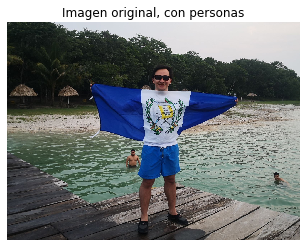

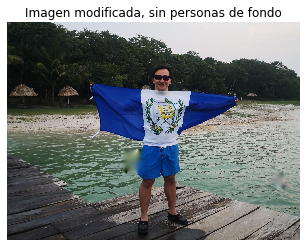

In [ ]:
# Import the module from restoration
from skimage.restoration import inpaint


imgName = "./imagenes/bandera.jpg"    
imgBandera = cv2.imread(imgName)
imgBanderaRGB = cv2.cvtColor(imgBandera, cv2.COLOR_BGR2RGB)
print("Dimensiones: ",imgBanderaRGB.shape)


# Initialize the mask
mask = np.zeros(imgBanderaRGB.shape[:-1])

# Set the pixels where the logo is to 1
#mask[690:840, 650:741] = 1
#mask[824:941, 1470:1600] = 1
mask[710:845, 648:755] = 1
mask[839:935, 1490:1559] = 1


# Apply inpainting to remove the logo
imgBanderaSinChatios = inpaint.inpaint_biharmonic(imgBanderaRGB,
                                  mask,
                                 multichannel=True)

# Show the original and logo removed images
show_image(imgBanderaRGB, 'Imagen original, con personas')
show_image(imgBanderaSinChatios, 'Imagen modificada, sin personas de fondo')

## Eliminar o agregar ruido a una imagen
Se utiliza si se desea dar un efecto de antiguedad a una imágen, o bien para quitar defectos que el sensor de la cámara ha capturado.  
Existen diversos métodos para quitar el ruido:  
+ Variación total (TV) 
Aplica el filtro de forma general.
+ Bilateral
Sirve para conservar los bordes o lineas
+ Wavelet denoising
+ No local

### Agregar ruido a una imagen

Dimensiones:  (744, 992, 3)


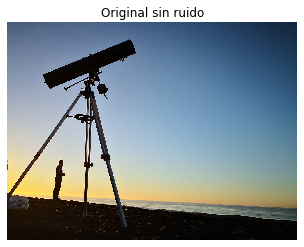

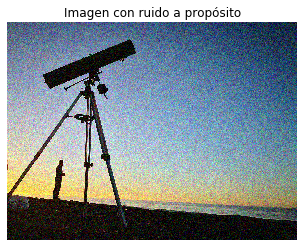

In [ ]:
# Import the module and function
from skimage.util  import random_noise

imgName = "./imagenes/telescopio.jpg"    
imgTelescoio = cv2.imread(imgName)
imgTelescoioRGB = cv2.cvtColor(imgTelescoio, cv2.COLOR_BGR2RGB)
print("Dimensiones: ",imgTelescoioRGB.shape)

# Add noise to the image
imgTelescoioConRuido = random_noise(imgTelescoioRGB)

# Show original and resulting image
show_image(imgTelescoioRGB, 'Original sin ruido')
show_image(imgTelescoioConRuido, 'Imagen con ruido a propósito')

### Reducción de ruido por el método de variación total


Dimensiones:  (744, 992, 3)


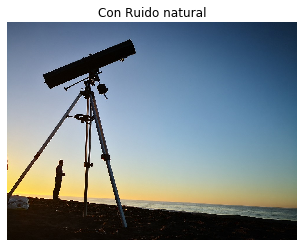

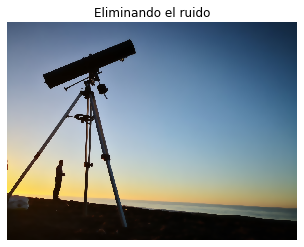

In [ ]:
# Import the module and function
from skimage.restoration import denoise_tv_chambolle

imgName = "./imagenes/telescopio.jpg"    
imgTelescoio = cv2.imread(imgName)
imgTelescoioRGB = cv2.cvtColor(imgTelescoio, cv2.COLOR_BGR2RGB)
print("Dimensiones: ",imgTelescoioRGB.shape)

# Apply total variation filter denoising
imgTelescoioSinRuido = denoise_tv_chambolle(imgTelescoioRGB, 
                                      multichannel=True)

# Show the noisy and denoised images
show_image(imgTelescoioRGB, 'Con Ruido natural')
show_image(imgTelescoioSinRuido, 'Eliminando el ruido')

### Superpixeles y Segmentación

Como se puede observar en los ejemplos anteriores, el borrado de objetos puede no ser muy preciso. Una de las técnicas de poder tener mejor presición es dividiendo la imágen, para ello se tiene el concepto de:  
+ Superpixeles  
Son partes de la imagen que se dividen por tener color o forma común. 
+ Segmentación  
Es la cantidad de veces que la imágen se divide, el default de la librería a utilizar es de 100, sin embargo se puede asignar manualmente.  

La finalidad de hacer segmentaciones es separar las partes de una imágen, por ejemplo en una tomografía se desea separar el área que tiene un tumor, o en el caso de querer reconocer frutas, es necesario separarlas por color o forma, posterior a ello, realizar una binarización de la imagen para quitar el fondo o el frente de la imágen. Hay algoritmos de inteligencia artificial que ya lo hacen, el más común es por medio de K-means.  
  
**Observar:**
En el ejemplo siguiente se utilizan dos imagenes que contienen rostros, al momento de realizar la segmentación por medio de superpixeles, se obtiene una nueva imagen, dicho resultado será mas fácil de procesar para un algoritmo de reconocimiento facial ya que se pueden identificar áreas del rostro.

Dimensiones Mariana:  (1072, 848, 3)
Dimensiones Cara:  (1432, 1416, 3)


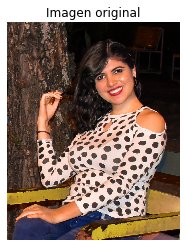

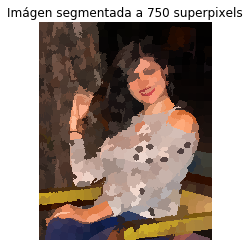

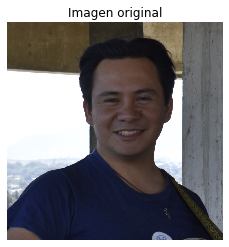

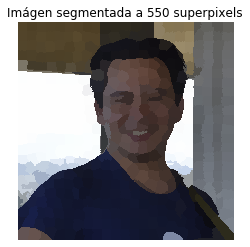

In [ ]:
# Import the slic function from segmentation module
from skimage.segmentation import slic
# Import the label2rgb function from color module
from skimage.color import label2rgb


imgName = "./imagenes/Mariana.jpg"    
imgMariana = cv2.imread(imgName)
imgMarianaRGB = cv2.cvtColor(imgMariana, cv2.COLOR_BGR2RGB)
print("Dimensiones Mariana: ",imgMarianaRGB.shape)

imgName2 = "./imagenes/cara.jpg"    
imgCara = cv2.imread(imgName2)
imgCaraRGB = cv2.cvtColor(imgCara, cv2.COLOR_BGR2RGB)
print("Dimensiones Cara: ",imgCaraRGB.shape)




# Obtain the segmentation with 400 regions
segmentsMariana = slic(imgMarianaRGB, n_segments= 750)
segmentsCara = slic(imgCaraRGB, n_segments= 550)

# Put segments on top of original image to compare
imgMarianaRGB_Segmentada = label2rgb(segmentsMariana, imgMarianaRGB, kind='avg')
imgCaraRGB_Segmentada = label2rgb(segmentsCara, imgCaraRGB, kind='avg')

# Show the segmented image
show_image(imgMarianaRGB, "Imagen original")
show_image(imgMarianaRGB_Segmentada, "Imágen segmentada a 750 superpixels")

show_image(imgCaraRGB, "Imagen original")
show_image(imgCaraRGB_Segmentada, "Imágen segmentada a 550 superpixels")


### Identificación de contornos
Para identificar objetos es necesario analizar las imágenes por medio de sus bordes o contornos, dicha acción podra servir para contar objetos, identificar figuras, etc.  
Casi siempre se va a tener una imagen a color RGB y para poder encontrar los bordes o contornos se deben seguir los siguientes pasos:
+ Transformar la imagen de RGB a gris
+ Transformar de gris a blanco y negro (binarización)
+ Encontrar los bordes por medio de la función de Scikit image.

### Explorando y entendiendo la función: contours = measure.find_contours(binary, 0.9)
Se puede observar que la función devuelve una matriz de dos dimensiones, siendo de (n,2), es decir, muchas filas y siempre 2 columnas. Los valores de que contiene corresponde a una línea de contorno, por lo que pueden ser valores mayores a 255 porque no son tonalidades, son puntos cartesianos; tomar en cuenta que, los puntos corresponden a coordenadas X,Y los cuáles pueden graficarse por medio de PLT de dos variables. Es muy importante entender que son 2 variables X y Y que representan al eje de las abcisas(horizontal) y al eje de las ordenadas(vertical), los cuales son puntos que unidos representan a una línea. Hago la observación ya que al ser una matriz de Nx2, puede confundirse con las imágenes que son matrices de NxM, con la aclaración que en una imagen, cada posición de la matriz representa una tonalidad, un pixel, dicho valor va entre 0 y 255.  
Ejemplo:  
En una matriz de imagen, la fila 0 y columna 0, puede tener el valor 127, esto significa que es un color medio, entre negro y blanco.  
En una matriz de contorno, de Nx2, la posición (0,0) del arreglo puede tener un valor 127 pero solito ese punto no dice nada, se necesita una pareja de puntos, por ejemplo, en relación a la posición (0,1) si tuviera un valor 300, significa que hay un punto que trazar con los valores (127,300).  

¿Por qué se hace esta aclaración?
Porque si deseamos graficar una imagen, se va a utilizar la función **show_image()**.  
Si se desea graficar un contorno, es necesario utilizar pyplot, con coordenadas X y Y.  

#### Ejemplo de contornos:



In [ ]:
# Import the measure module
import numpy as np
import cv2
from skimage import measure, color
from skimage.filters import threshold_otsu

imgName = "./imagenes/dados.JPG"    
imgDado = cv2.imread(imgName)
imgDadoRGB = cv2.cvtColor(imgDado, cv2.COLOR_BGR2RGB)
print("Dimensiones Imagen de Dados: ",imgDadoRGB.shape)

# Make the image grayscale
imgDadoGris = color.rgb2gray(imgDadoRGB)

# Obtain the optimal thresh value
thresh = threshold_otsu(imgDadoGris)

# Apply thresholding
binary = imgDadoGris > thresh

# Find contours at a constant value of 0.8
contours = measure.find_contours(binary, 0.9)
print("Observar que el tipo de dato de Contours es una lista: ", type(contours))
print("Observar la cantidad de dimensiones de Contours, o en otras palabras, la cantidad de elementos, cada elemento es un contorno: ", np.shape(contours))
print("Ahora, se analiza el tipo de dato de un elemento de la lista de Contours, observar que es un arreglo:",type(contours[0]))
print("Cantidad de dimensiones de un arreglo, especificamente el Contours[0]: ", np.shape(contours[0]))
print("Tamaño de cada arreglo que hay en la lista de contornos: ")
for contour in contours:
    print(contour.shape)    

print("Impresión del contenido de cada arreglo que hay en la lista de contornos: ")


for i, contour in enumerate(contours):

    numeroImagen="Imagen " + str(i)
    #show_image(contour,numeroImagen)
    print(numeroImagen)
    print(contour)
    


print("Si se desea acceder a una posición específica de un contorno, podría hacerse asi: ")
contorno0=contours[0]
print("Posición 5: ",contorno0[5])
print("Posición 5,0: ",contorno0[5][0])
print("Posición 5,1: ",contorno0[5][1])
print("Cada uno de los puntos anteriores formará una línea")

# concatenar todos los ndarray en uno solo
#X=np.concatenate((contours[0], contours[1], contours[2], contours[3], contours[4], contours[5], contours[6], contours[7]), axis=0)
#show_image(X)

#show_image_contour(imgDadosGris, contours)
#show_image(contours)


Dimensiones Imagen de Dados:  (108, 150, 3)
Observar que el tipo de dato de Contours es una lista:  <class 'list'>
Observar la cantidad de dimensiones de Contours, o en otras palabras, la cantidad de elementos, cada elemento es un contorno:  (13,)
Ahora, se analiza el tipo de dato de un elemento de la lista de Contours, observar que es un arreglo: <class 'numpy.ndarray'>
Cantidad de dimensiones de un arreglo, especificamente el Contours[0]:  (237, 2)
Tamaño de cada arreglo que hay en la lista de contornos: 
(237, 2)
(201, 2)
(33, 2)
(35, 2)
(37, 2)
(197, 2)
(165, 2)
(35, 2)
(33, 2)
(35, 2)
(37, 2)
(33, 2)
(37, 2)
Impresión del contenido de cada arreglo que hay en la lista de contornos: 
Imagen 0
[[ 69.   99.9]
 [ 68.9 100. ]
 [ 68.9 101. ]
 [ 68.9 102. ]
 [ 68.  102.9]
 [ 67.9 103. ]
 [ 67.9 104. ]
 [ 67.9 105. ]
 [ 67.  105.9]
 [ 66.9 106. ]
 [ 66.9 107. ]
 [ 66.9 108. ]
 [ 66.  108.9]
 [ 65.9 109. ]
 [ 65.9 110. ]
 [ 65.9 111. ]
 [ 65.  111.9]
 [ 64.9 112. ]
 [ 64.9 113. ]
 [ 64.9 11

### Conteo de objetos por medio de contornos

Cada contorno que se identifica en la matriz de contornos, va a tener un tamaño, usualmente se reconocen los colores blancos (recordar que la imagen de entrada es un binarizada).  
Sabiendo el tamaño de un contorno, y la concurrencia, se puede identificar qué objeto es, como se muestra en el siguiente 
ejemplo para contar los puntos de un dado.

Dimensiones Imagen de Dados:  (876, 1270, 3)


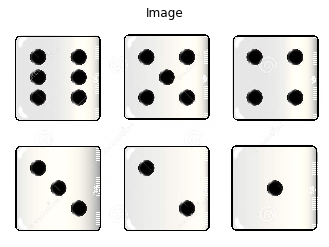

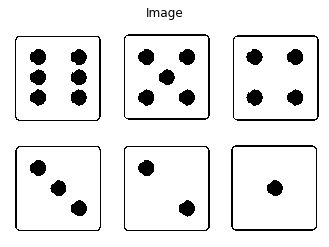

Extraer las columnas a manera que la columna 0 sea X, y la columna 1 sea Y


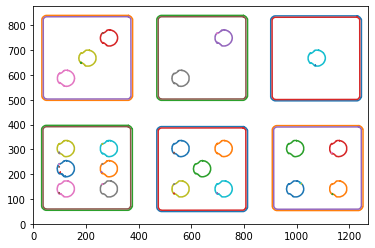

In [ ]:
# Import the measure module
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import measure, color
from skimage.filters import threshold_otsu


def graficarTodosLosContornos(contours,alto, ancho):
    for i, contour in enumerate(contours):
        x1=contour[:,1]
        y1=contour[:,0]

        numeroImagen="Imagen " + str(i) + str(contours)
        #print(numeroImagen)
        #876, 1270
        plt.axis([0, alto, 0, ancho])
        plt.plot(x1,y1)
    plt.show()


def graficarContornosSeparados(contours,alto,ancho):   
    for i, contour in enumerate(contours):
        x1=contour[:,1]
        y1=contour[:,0]

        numeroImagen="Imagen " + str(i) + str(contours)
        #print(numeroImagen)
        print("Contorno ", i,": Dimensiones de: ",contour.shape)
        plt.axis([0, alto, 0, ancho])
        plt.plot(x1,y1)
        plt.show()
        
        
imgName = "./imagenes/dados3.JPG"    
imgDado = cv2.imread(imgName)
imgDadoRGB = cv2.cvtColor(imgDado, cv2.COLOR_BGR2RGB)
print("Dimensiones Imagen de Dados: ",imgDadoRGB.shape)

# Make the image grayscale
imgDadoGris = color.rgb2gray(imgDadoRGB)

# Obtain the optimal thresh value
thresh = threshold_otsu(imgDadoGris)

# Apply thresholding
binary = imgDadoGris > thresh

# Find contours at a constant value of 0.6
contours = measure.find_contours(binary, 0.6)

show_image(imgDadoRGB)
show_image(binary)

print("Extraer las columnas a manera que la columna 0 sea X, y la columna 1 sea Y")

graficarTodosLosContornos(contours,imgDadoRGB.shape[1],imgDadoRGB.shape[0])

    


Si se desea visualizar cada contorno por separado, ejecutar la siguiente instrucción:

Contorno  0 : Dimensiones de:  (1373, 2)


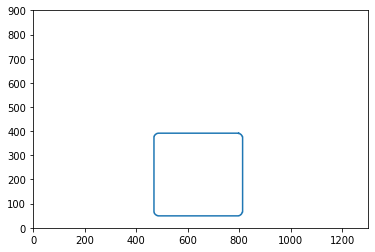

Contorno  1 : Dimensiones de:  (1373, 2)


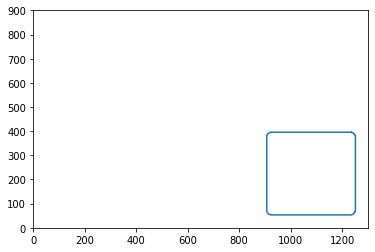

Contorno  2 : Dimensiones de:  (1373, 2)


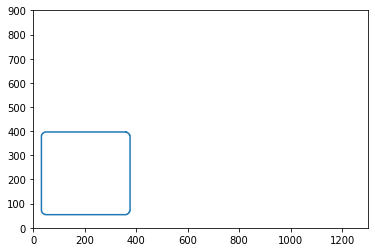

Contorno  3 : Dimensiones de:  (1331, 2)


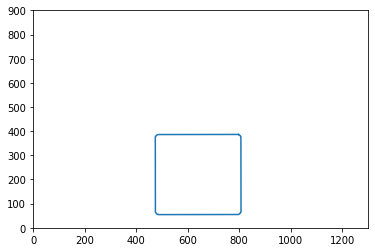

Contorno  4 : Dimensiones de:  (1331, 2)


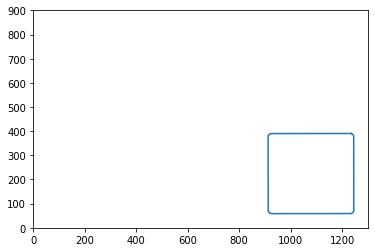

Contorno  5 : Dimensiones de:  (1331, 2)


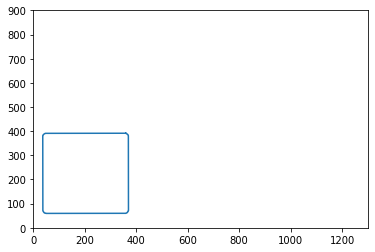

Contorno  6 : Dimensiones de:  (275, 2)


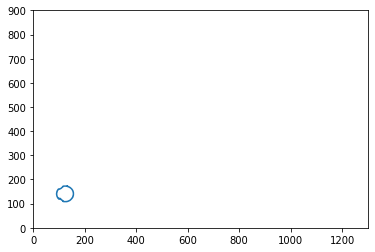

Contorno  7 : Dimensiones de:  (265, 2)


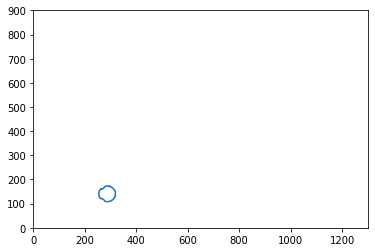

Contorno  8 : Dimensiones de:  (265, 2)


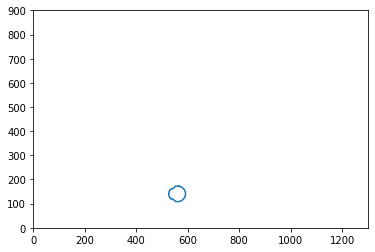

Contorno  9 : Dimensiones de:  (273, 2)


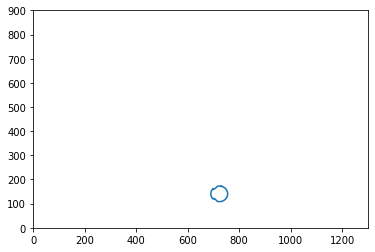

Contorno  10 : Dimensiones de:  (269, 2)


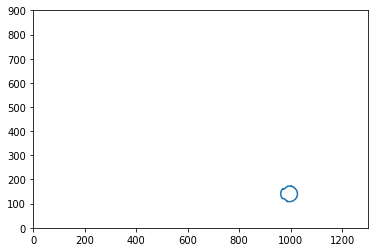

Contorno  11 : Dimensiones de:  (265, 2)


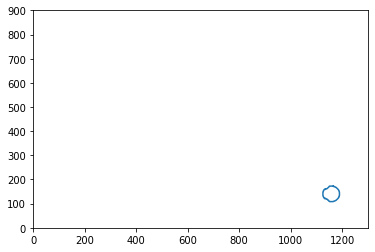

Contorno  12 : Dimensiones de:  (5, 2)


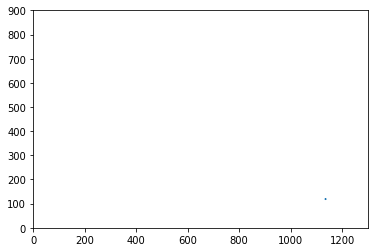

Contorno  13 : Dimensiones de:  (5, 2)


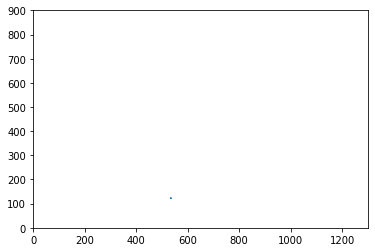

Contorno  14 : Dimensiones de:  (7, 2)


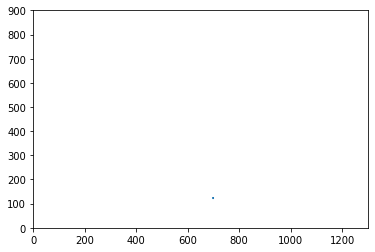

Contorno  15 : Dimensiones de:  (5, 2)


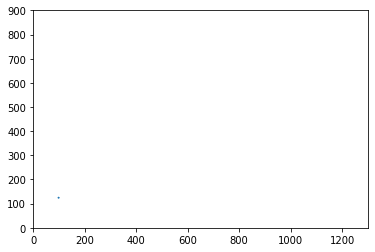

Contorno  16 : Dimensiones de:  (5, 2)


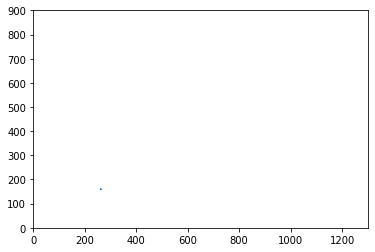

Contorno  17 : Dimensiones de:  (5, 2)


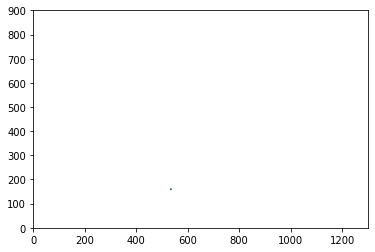

Contorno  18 : Dimensiones de:  (5, 2)


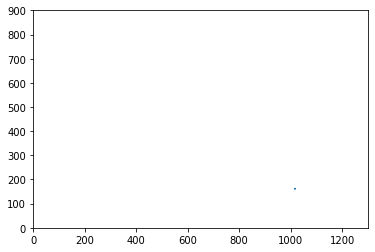

Contorno  19 : Dimensiones de:  (5, 2)


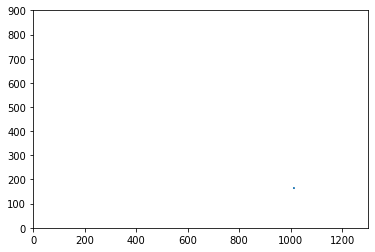

Contorno  20 : Dimensiones de:  (297, 2)


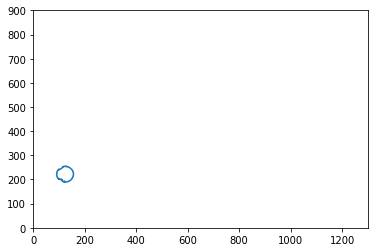

Contorno  21 : Dimensiones de:  (279, 2)


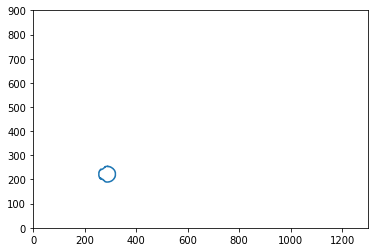

Contorno  22 : Dimensiones de:  (267, 2)


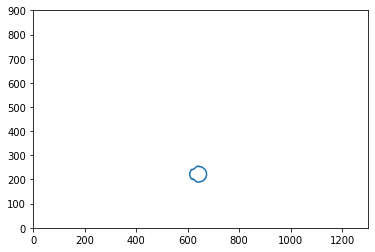

Contorno  23 : Dimensiones de:  (5, 2)


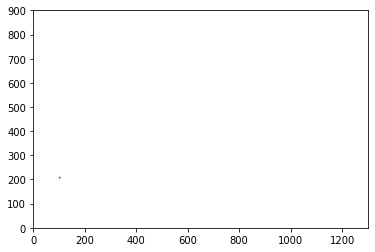

Contorno  24 : Dimensiones de:  (5, 2)


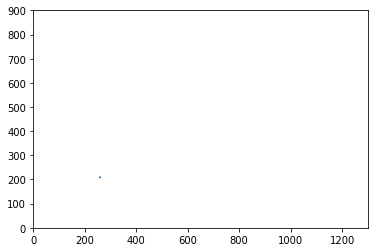

Contorno  25 : Dimensiones de:  (5, 2)


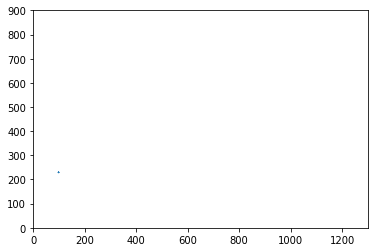

Contorno  26 : Dimensiones de:  (5, 2)


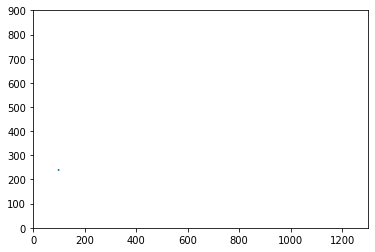

Contorno  27 : Dimensiones de:  (5, 2)


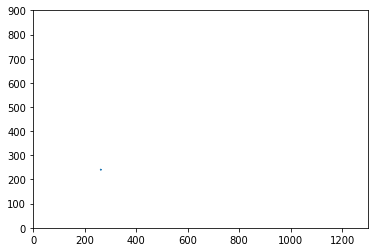

Contorno  28 : Dimensiones de:  (275, 2)


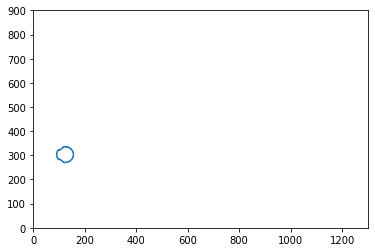

Contorno  29 : Dimensiones de:  (273, 2)


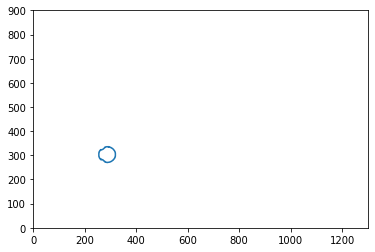

Contorno  30 : Dimensiones de:  (271, 2)


In [ ]:
graficarContornosSeparados(contours,1300,900)

****Procedimiento para contar los objetos deseados**** 
+ 1. Identificar el tamaño de cada contorno, por ejemplo, los cuadrados será de dimensiones mas grandes que los circulos de cada dado.
+ 2. Crear función que cuente en base a un rango de tamaño, por ejemplo, si los circulos son de tamaño entre 50 y 75, contar cuántos contornos hay en ese rango.  

Como se puede observar por medio de la función de *graficarContornosSeparados()*, hay un tamaño para cada contorno, si se desea observar todos los tamaños, se procede a leer el arreglo de contornos.  
Conociendo su tamaño, solo hace falta hacer un conteo, por ejemplo para los cuadrados, se requiere un conteo cada vez que el size sea mayor a 1300, en cambio, para los puntos, sería entre el rango de 200 a 300 de forma muy general y no precisa.



In [ ]:
# Analizar tamaño de los contornos:
def mostrarTamanoContornos(contornos):
    for i, contorno in enumerate(contornos):
        numeroImagen="Imagen " + str(i)
        #show_image(contour,numeroImagen)
        print("Contorno ", i,": Dimensiones de: ",contorno.shape)
        
mostrarTamanoContornos(contours)

### Conteo de objetos
Se crean rangos para analizar la cantidad de objetos identificados, según los contornos.

In [ ]:
# Create list with the shape of each contour

def contarObjetos(listaDeContornos,rangoMinimo,rangoMaximo):
    objetosEncontrados=0
    listaDeTamanoDeContornos = [i.shape[0] for i in listaDeContornos]
    
    # Hay dos formas de contar los objetos:
    # 1. La forma rápida, en una línea, tomar en cuenta que se crea una lista:
    #objetosEncontrados = [j for j in contours if (np.shape(j)[0] < rangoMaximo ) and np.shape(j)[0] >rangoMinimo]
    
    # 2. La forma mas elaborada, mas intuitiva visualmente:
    
    for indice, contorno in enumerate(listaDeTamanoDeContornos):
        if contorno < rangoMaximo  and contorno > rangoMinimo:
            objetosEncontrados+=1
            
    return objetosEncontrados
        
    # Shows all contours found 
    #show_image_contour(binary, contours)
    #print("Cantidad de objetos encontrados: {}. ".format(len(objetosEncontrados)))

contarCuadradados=contarObjetos(contours,1300,1400)
contarPuntos=contarObjetos(contours,200,300)
print("Cantidad de cuadrados: ",contarCuadradados)
print("Cantidad de puntos en los dados: ",contarPuntos)


Si se desea ver únicamente los valores de cada contorno:

In [ ]:
def mostrarContornoComoNumeros(listaDeContornos):
    listaDeTamanoDeContornos = [i.shape[0] for i in listaDeContornos]
    return listaDeTamanoDeContornos

mostrarContornoComoNumeros(contours)


# Resumen y método final ya optimizado
## Código unificado para el conteo

In [ ]:
# Import the measure module
from skimage.filters import threshold_otsu
from skimage import measure, color
import matplotlib.pyplot as plt
import numpy as np
import cv2

########################################################################
######### DEFINICIÓN DE TODAS LAS FUNCIONES UTILIZADAS #################
########################################################################

def show_image(image, title='Image', cmap_type='gray'):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

def graficarTodosLosContornos(contours,pathImagen):
    
    imgOrigen = cv2.imread(pathImagen)
    imgOrigenRGB = cv2.cvtColor(imgOrigen, cv2.COLOR_BGR2RGB)
    print("Dimensiones de imagen origen ",pathImagen,":  ",imgOrigenRGB.shape)
    
   
    alto=imgOrigenRGB.shape[1]
    ancho=imgOrigenRGB.shape[0]
    
    
    for i, contour in enumerate(contours):
        x1=contour[:,1]
        y1=contour[:,0]

        numeroImagen="Imagen " + str(i) + str(contours)
        #print(numeroImagen)
        #876, 1270
        plt.axis([0, alto, 0, ancho])
        plt.plot(x1,y1)
    plt.show()


def graficarContornosSeparados(contours,pathImagen):
    imgOrigen = cv2.imread(pathImagen)
    imgOrigenRGB = cv2.cvtColor(imgOrigen, cv2.COLOR_BGR2RGB)
    print("Dimensiones de imagen origen ",pathImagen,":  ",imgOrigenRGB.shape)
    
    
    alto=imgOrigenRGB.shape[1]
    ancho=imgOrigenRGB.shape[0]

    
    for i, contour in enumerate(contours):
        x1=contour[:,1]
        y1=contour[:,0]

        numeroImagen="Imagen " + str(i) + str(contours)
        #print(numeroImagen)
        print("Contorno ", i,": Dimensiones de: ",contour.shape)
        plt.axis([0, alto, 0, ancho])
        plt.plot(x1,y1)
        plt.show()

def contarObjetos(listaDeContornos,rangoMinimo,rangoMaximo):
    objetosEncontrados=0
    listaDeTamanoDeContornos = [i.shape[0] for i in listaDeContornos]
    
    # Hay dos formas de contar los objetos:
    # 1. La forma rápida, en una línea, tomar en cuenta que se crea una lista:
    #objetosEncontrados = [j for j in contours if (np.shape(j)[0] < rangoMaximo ) and np.shape(j)[0] >rangoMinimo]
    
    # 2. La forma mas elaborada, mas intuitiva visualmente:
    
    for indice, contorno in enumerate(listaDeTamanoDeContornos):
        if contorno < rangoMaximo  and contorno > rangoMinimo:
            objetosEncontrados+=1
            
    return objetosEncontrados
        
def mostrarContornoComoNumeros(listaDeContornos,rangoMinimo,rangoMaximo):
    listaDeTamanoDeContornos = [i.shape[0] for i in listaDeContornos]
    return listaDeTamanoDeContornos
    
    ########################################################################
    ######### FUNCIÓN PRINCIPAL PARA CONTAR OBJETOS        #################
    ########################################################################

    
def analizarImagenParaContarObjetos(pathImagen):
    
    #imgName = "./imagenes/dados4.JPG"    
    #imgName = "./imagenes/bolas.jpg"    
    imgDado = cv2.imread(pathImagen)
    imgDadoRGB = cv2.cvtColor(imgDado, cv2.COLOR_BGR2RGB)
    print("Dimensiones Imagen de Dados: ",imgDadoRGB.shape)
    ancho=imgDadoRGB.shape[1]
    alto=imgDadoRGB.shape[0]


    # Make the image grayscale
    imgDadoGris = color.rgb2gray(imgDadoRGB)

    # Obtain the optimal thresh value
    thresh = threshold_otsu(imgDadoGris)

    # Apply thresholding
    binary = imgDadoGris > thresh

    # Find contours at a constant value of 0.6
    contours = measure.find_contours(binary, 0.6)

    show_image(imgDadoRGB)
    show_image(binary)

    listaCantidadContornos=mostrarContornoComoNumeros(contours,ancho, alto)
    print("Cantidad de contornos: ",len(listaCantidadContornos))
    print("Mostrar magnitud de contornos", listaCantidadContornos)

    return contours
    
    
    #graficarTodosLosContornos(contours,ancho, alto)
    
    
    #graficarContornosSeparados(contours,ancho, alto)


#contarCuadradados=contarObjetos(contours,1300,1400)
#contarPuntos=contarObjetos(contours,200,300)
#print("Cantidad de cuadrados: ",contarCuadradados)
#print("Cantidad de puntos en los dados: ",contarPuntos)


    


## Usar método para conteo de puntos en un dado


In [ ]:
pathImagen="./imagenes/dados4.JPG"    
misContornos=analizarImagenParaContarObjetos(pathImagen)
graficarTodosLosContornos(misContornos,pathImagen)

print("#### RESULTADOS ######")
contarCuadradados=contarObjetos(misContornos,1300,1400)
contarPuntos=contarObjetos(misContornos,200,300)
print("Cantidad de cuadrados: ",contarCuadradados)
print("Cantidad de puntos en los dados: ",contarPuntos)


graficarContornosSeparados(misContornos,pathImagen)



## Usar método para conteo de macadamias

In [ ]:
pathImagen="./imagenes/bolas.jpg"    
misContornos=analizarImagenParaContarObjetos(pathImagen)
graficarTodosLosContornos(misContornos,pathImagen)

#print("#### RESULTADOS ######")
#contarCuadradados=contarObjetos(misContornos,1300,1400)
#contarPuntos=contarObjetos(misContornos,200,300)
#print("Cantidad de cuadrados: ",contarCuadradados)
#print("Cantidad de puntos en los dados: ",contarPuntos)

#graficarContornosSeparados(misContornos,pathImagen)
